In [80]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
from util.best import load_best, load_parameters
from util.eval import evaluate
from util.val_datasets import val_dataset
from util.dataset import load_semeval_meta
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef

In [3]:
EXPERIMENT = 'albert-large-v2-semeval-sas'
DATASET_CONFIG = ('sciEntsBank', 'unseen_answers', 'en')

In [4]:
BEST, MODEL, TOKENIZER = load_best(EXPERIMENT)
PARAMETERS = load_parameters(EXPERIMENT)
META = np.array(list(load_semeval_meta(*DATASET_CONFIG)))
DATASET = val_dataset(*(DATASET_CONFIG + (TOKENIZER, PARAMETERS['SEQUENCE_LENGTH'])))


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [5]:
scores, (y_true, y_pred_raw) = evaluate(MODEL.cuda(), tqdm(DATASET))

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [04:02<00:00,  3.19s/it]


In [173]:
pd.DataFrame([dict(scores)])

,precision_3_way,recall_3_way,f1_macro_3_way,f1_micro_3_way,matthews_3_way,accuracy_3_way,precision_2_way_projected,recall_2_way_projected,f1_macro_2_way_projected,f1_micro_2_way_projected,matthews_2_way_projected,accuracy_2_way_projected
0,0.676298,0.677769,0.649258,0.677769,0.500762,0.677769,0.793359,0.776853,0.775231,0.776853,0.563746,0.776853


In [175]:
predictions = pd.DataFrame({
    'exercise_id': META[:, 0],
    'reference_id': META[:, 1],
    'answer_id': META[:, 2],
    'reference': META[:, 0],
    'answer': META[:, 1],
    'contradictory': y_pred_raw[:, 0], 
    'incorrect': y_pred_raw[:, 1], 
    'correct': y_pred_raw[:, 2],
    'prediction': y_pred_raw.argmax(1),
    'label': y_true,
})

In [174]:
summed = predictions.copy()
summed['references'] = 1
summed = summed.groupby([ 'exercise_id', 'answer_id', 'label' ]).sum().reset_index()
summed['prediction'] = summed[['contradictory', 'incorrect', 'correct']].idxmax(axis = 1).replace({'correct': 2, 'incorrect': 1, 'contradictory': 0})

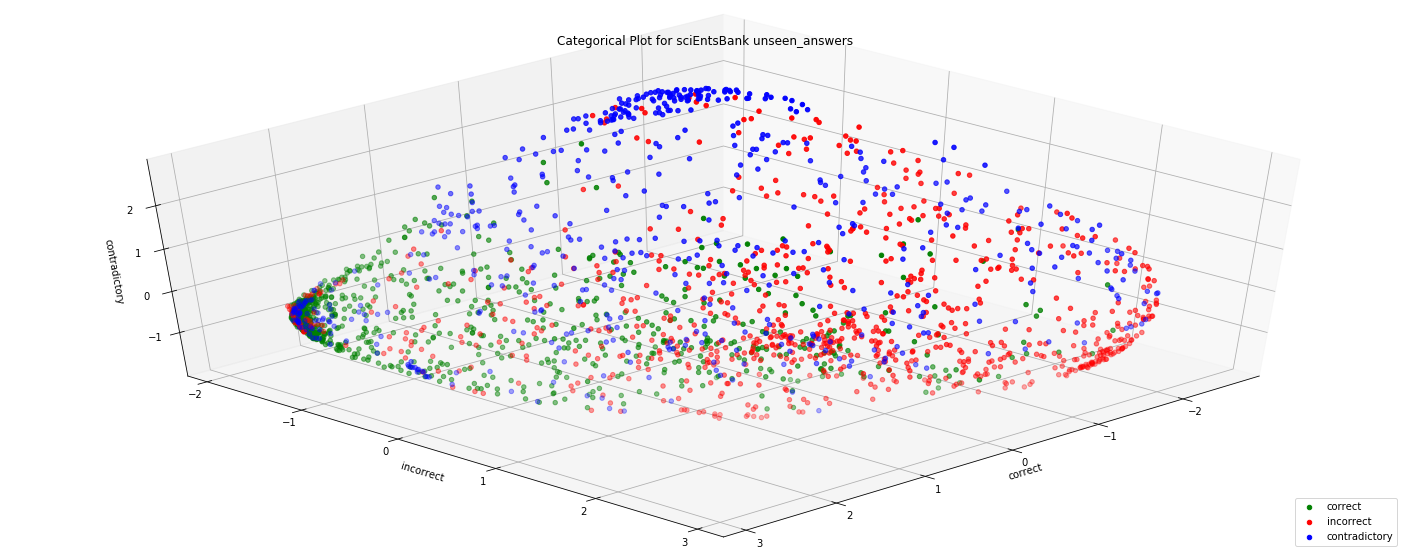

In [183]:
#%matplotlib notebook

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection='3d')

def scatter(predictions, label, name, color):
    ax.scatter(
        predictions[predictions['label'] == label]['correct'],
        predictions[predictions['label'] == label]['incorrect'], 
        predictions[predictions['label'] == label]['contradictory'], 
        c = color,
        label = name
    )

scatter(predictions, 2, 'correct', 'green')
scatter(predictions, 1, 'incorrect', 'red')
scatter(predictions, 0, 'contradictory', 'blue')

ax.view_init(45, 45)
ax.set_xlabel('correct')
ax.set_ylabel('incorrect')
ax.set_zlabel('contradictory')
plt.title('Categorical Plot for {} {}'.format(DATASET_CONFIG[0], DATASET_CONFIG[1]))
plt.legend(loc="lower right")
plt.show()

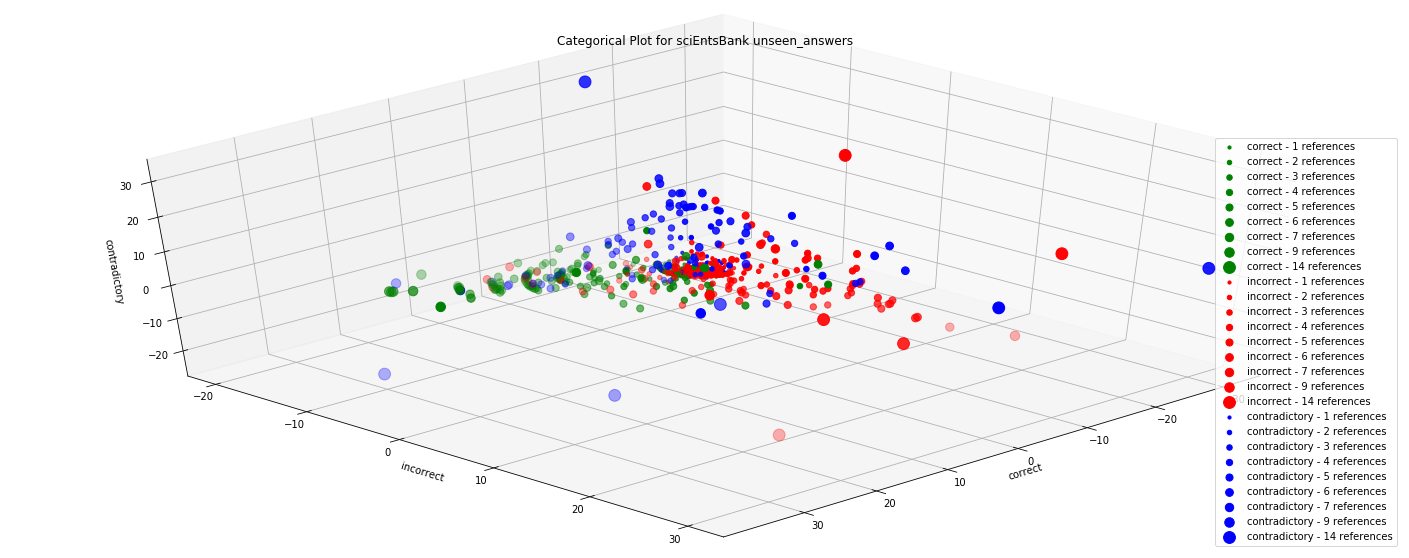

In [182]:
#%matplotlib notebook

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection='3d')

def scatter(predictions, label, name, color):
    counts = predictions['references'].unique()
    counts.sort()
    for count in counts:
        sub = predictions[predictions['references'] == count]
        ax.scatter(
            sub[sub['label'] == label]['correct'],
            sub[sub['label'] == label]['incorrect'], 
            sub[sub['label'] == label]['contradictory'], 
            c = color,
            label = '%s - %s references' % (name, count),
            s = count * 10
        )

scatter(summed, 2, 'correct', 'green')
scatter(summed, 1, 'incorrect', 'red')
scatter(summed, 0, 'contradictory', 'blue')

ax.view_init(45, 45)
ax.set_xlabel('correct')
ax.set_ylabel('incorrect')
ax.set_zlabel('contradictory')
plt.title('Categorical Plot for {} {}'.format(DATASET_CONFIG[0], DATASET_CONFIG[1]))
plt.legend(loc="lower right")
plt.show()

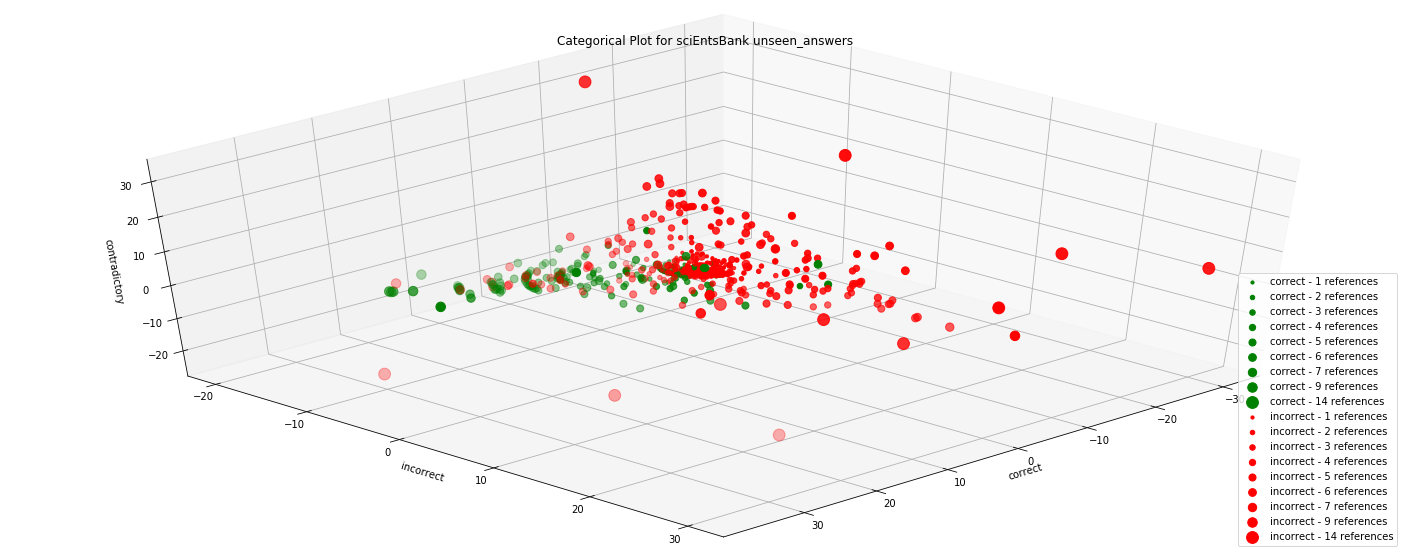

In [184]:
#%matplotlib notebook

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(111, projection='3d')

def scatter(predictions, label, name, color):
    counts = predictions['references'].unique()
    counts.sort()
    for count in counts:
        sub = predictions[predictions['references'] == count]
        ax.scatter(
            sub[sub['label'].isin(label)]['correct'],
            sub[sub['label'].isin(label)]['incorrect'], 
            sub[sub['label'].isin(label)]['contradictory'], 
            c = color,
            label = '%s - %s references' % (name, count),
            s = count * 10
        )

scatter(summed, [2], 'correct', 'green')
scatter(summed, [1,0], 'incorrect', 'red')

ax.view_init(45, 45)
ax.set_xlabel('correct')
ax.set_ylabel('incorrect')
ax.set_zlabel('contradictory')
plt.title('Categorical Plot for {} {}'.format(DATASET_CONFIG[0], DATASET_CONFIG[1]))
plt.legend(loc="lower right")
plt.show()

In [163]:
eval_df = pd.DataFrame(columns = [
    'references',
    'samples',
    'f1 macro',
    'f1 micro',
    'matthews corrcoef',
    'precision score',
    'recall score',
    'accuracy score'
])

eval_df['references'] = eval_df['references'].astype(np.int)
eval_df['samples'] = eval_df['samples'].astype(np.int)

eval_df['f1 macro'] = eval_df['f1 macro'].astype(np.float)
eval_df['f1 micro'] = eval_df['f1 micro'].astype(np.float)
eval_df['matthews corrcoef'] = eval_df['matthews corrcoef'].astype(np.float)
eval_df['precision score'] = eval_df['precision score'].astype(np.float)
eval_df['recall score'] = eval_df['recall score'].astype(np.float)
eval_df['accuracy score'] = eval_df['accuracy score'].astype(np.float)


for count in summed['references'].unique():
    sub = summed[summed['references'] == count]
    eval_df = eval_df.append({
        'references': count,
        'samples': len(summed[summed['references'] == count]),
        'f1 macro': f1_score(sub['label'], sub['prediction'],average='macro'),
        'f1 micro': f1_score(sub['label'], sub['prediction'], average='micro'),
        'matthews corrcoef': matthews_corrcoef(sub['label'], sub['prediction']),
        'precision score': precision_score(sub['label'], sub['prediction'], labels=list(range(3)), average='weighted'),
        'recall score': recall_score(sub['label'], sub['prediction'], labels=list(range(3)), average='weighted'),
        'accuracy score': accuracy_score(sub['label'], sub['prediction']),
    }, ignore_index=True)

eval_df.sort_values('f1 micro')

,references,samples,f1 macro,f1 micro,matthews corrcoef,precision score,recall score,accuracy score
7,14.0,11.0,0.305556,0.454545,0.129099,0.532468,0.454545,0.454545
3,6.0,47.0,0.489283,0.553191,0.311947,0.526872,0.553191,0.553191
0,1.0,579.0,0.527474,0.621762,0.342769,0.614079,0.621762,0.621762
5,2.0,56.0,0.585137,0.678571,0.490738,0.706583,0.678571,0.678571
4,5.0,94.0,0.703529,0.734043,0.563755,0.735848,0.734043,0.734043
1,3.0,49.0,0.761220,0.775510,0.654832,0.804082,0.775510,0.775510
2,4.0,121.0,0.767916,0.776860,0.675480,0.795571,0.776860,0.776860
6,9.0,10.0,0.619048,0.800000,0.661438,0.650000,0.800000,0.800000
8,7.0,12.0,0.538012,0.833333,0.547048,0.841667,0.833333,0.833333


In [164]:
eval_df = pd.DataFrame(columns = [
    'references',
    'samples',
    'delta f1 macro',
    'delta f1 micro',
    'delta matthews corrcoef',
    'delta precision score',
    'delta recall score',
    'delta accuracy score'
])

eval_df['references'] = eval_df['references'].astype(np.int)
eval_df['samples'] = eval_df['samples'].astype(np.int)

eval_df['delta f1 macro'] = eval_df['delta f1 macro'].astype(np.float)
eval_df['delta f1 micro'] = eval_df['delta f1 micro'].astype(np.float)
eval_df['delta matthews corrcoef'] = eval_df['delta matthews corrcoef'].astype(np.float)
eval_df['delta precision score'] = eval_df['delta precision score'].astype(np.float)
eval_df['delta recall score'] = eval_df['delta recall score'].astype(np.float)
eval_df['delta accuracy score'] = eval_df['delta accuracy score'].astype(np.float)


for count in summed['references'].unique():
    sub = summed[summed['references'] == count]
    single = predictions[predictions['exercise_id'].isin(sub['exercise_id']) & predictions['answer_id'].isin(sub['answer_id'])]

    eval_df = eval_df.append({
        'references': count,
        'samples': len(sub),
        'delta f1 macro': f1_score(sub['label'], sub['prediction'], average='macro') - f1_score(single['label'], single['prediction'], average='macro'),
        'delta f1 micro': f1_score(sub['label'], sub['prediction'], average='micro') - f1_score(single['label'], single['prediction'], average='micro'),
        'delta matthews corrcoef': matthews_corrcoef(sub['label'], sub['prediction']) - matthews_corrcoef(single['label'], single['prediction']),
        'delta precision score': precision_score(sub['label'], sub['prediction'], labels=list(range(3)), average='weighted') - precision_score(single['label'], single['prediction'], labels=list(range(3)), average='weighted'),
        'delta recall score': recall_score(sub['label'], sub['prediction'], labels=list(range(3)), average='weighted') - recall_score(single['label'], single['prediction'], labels=list(range(3)), average='weighted'),
        'delta accuracy score': accuracy_score(sub['label'], sub['prediction']) - accuracy_score(single['label'], single['prediction']),
    }, ignore_index=True)

eval_df.sort_values('delta f1 micro')

,references,samples,delta f1 macro,delta f1 micro,delta matthews corrcoef,delta precision score,delta recall score,delta accuracy score
8,7.0,12.0,-0.055556,-0.035714,-0.098345,0.000000,-0.035714,-0.035714
3,6.0,47.0,-0.030279,-0.024823,-0.041827,-0.037208,-0.024823,-0.024823
0,1.0,579.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,2.0,56.0,0.002085,0.000000,-0.001003,-0.001465,0.000000,0.000000
2,4.0,121.0,0.001884,0.004132,0.010337,0.011565,0.004132,0.004132
4,5.0,94.0,0.013554,0.004255,0.007541,0.008987,0.004255,0.004255
7,14.0,11.0,-0.014957,0.006494,-0.013803,-0.034609,0.006494,0.006494
6,9.0,10.0,0.078795,0.044444,0.105740,0.046294,0.044444,0.044444
1,3.0,49.0,0.085651,0.081633,0.132130,0.097770,0.081633,0.081633


In [165]:
summed = predictions.copy()
summed['references'] = 1
summed = summed.groupby([ 'exercise_id', 'answer_id', 'label' ]).sum().reset_index()
summed['incorrect'] = summed['incorrect'] + summed['contradictory']
summed['regression'] = summed['correct'] - summed['incorrect']

summed['correct_regression'] = summed['label'].replace({2:1})

summed.head()

,exercise_id,answer_id,label,contradictory,incorrect,correct,prediction,references,regression,correct_regression
0,0,0,1,-0.503676,1.480983,-0.486366,1,1,-1.967349,1
1,0,1,2,-0.450079,0.648351,0.377887,1,1,-0.270464,1
2,0,2,1,-0.245462,1.130216,-0.035091,1,1,-1.165307,1
3,0,3,0,-0.172849,1.240781,-0.227854,1,1,-1.468635,0
4,1,0,1,-0.819646,-0.577146,1.508422,2,1,2.085569,1


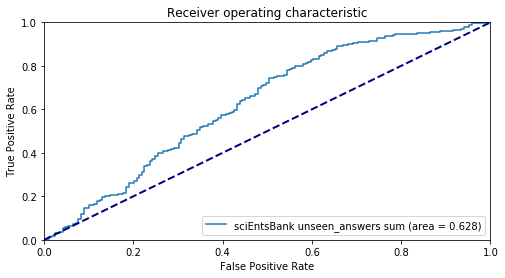

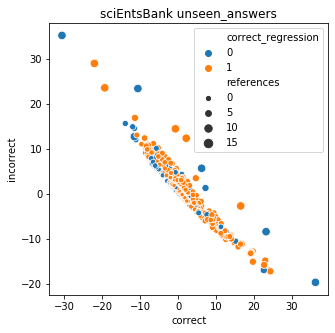

In [166]:
curve = roc_curve(
    summed['correct_regression'],
    summed['regression']
)

plt.figure(figsize=(8,4))
plt.plot(
    curve[0], 
    curve[1],
    label='%s %s sum (area = %0.03f)' % (DATASET_CONFIG[0], DATASET_CONFIG[1], auc(curve[0], curve[1]))
)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(5,5))
sns.scatterplot(
    x="correct", 
    y="incorrect",
    hue='correct_regression', 
    size='references', 
    data=summed).title.set_text('%s %s' % (DATASET_CONFIG[0], DATASET_CONFIG[1]))
plt.show()